In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample-jini/jini...png
/kaggle/input/einops-2/einops-0.8.0-py3-none-any.whl
/kaggle/input/sample-2/Screenshot 2024-09-12 002708.png
/kaggle/input/butterfly/Butterfly.jpg


In [2]:
!pip install /kaggle/input/einops-2/einops-0.8.0-py3-none-any.whl

Processing /kaggle/input/einops-2/einops-0.8.0-py3-none-any.whl


Epoch 0 loss: 0.325336
Epoch 500 loss: 0.000000
Epoch 1000 loss: 0.000000
Epoch 1500 loss: 0.000000
Epoch 2000 loss: 0.000000
Epoch 2500 loss: 0.000000


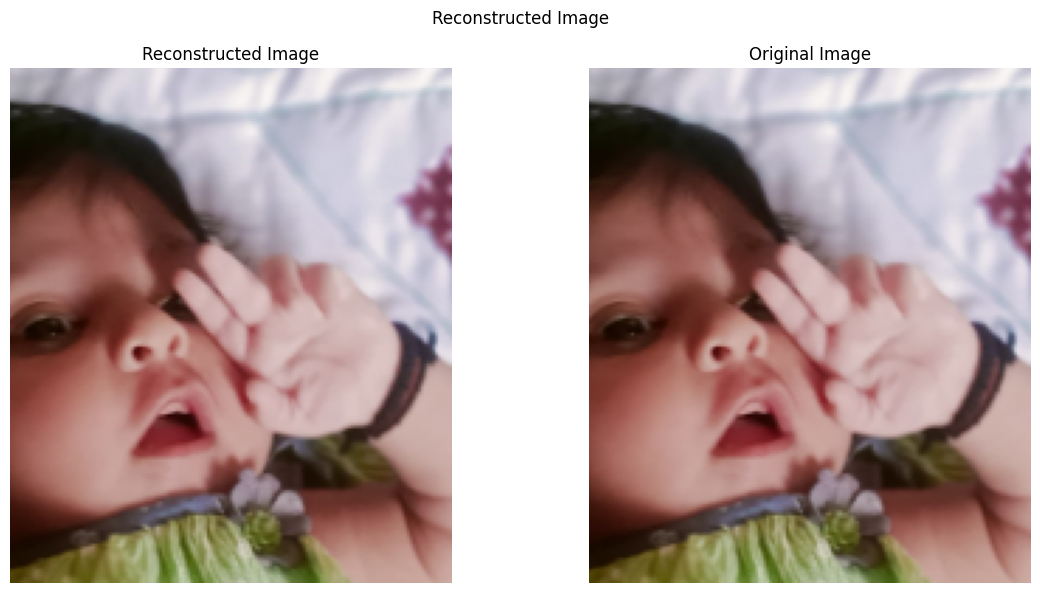

In [6]:
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error
import torch.nn as nn 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_path = "/kaggle/input/sample-jini/jini...png"
img = torchvision.io.read_image(img_path).float() / 255.0

if img.shape[0] == 4:
    img = img[0:3, :, :]

def create_coord_map(img):
    c, h, w = img.shape
    w_coords = torch.arange(w).repeat(h, 1).reshape(-1)
    h_coords = torch.arange(h).repeat(w, 1).t().reshape(-1)
    X = torch.stack([h_coords, w_coords], dim=1).float().to(device)
    Y = img.permute(1, 2, 0).reshape(-1, c).to(device)
    return X, Y

X, Y = create_coord_map(img)

def create_rff(X, n_feat, sigma):
    rff = RBFSampler(n_components=n_feat, gamma=1/(2 * sigma**2))
    X_transformed = rff.fit_transform(X.cpu().numpy())
    return torch.tensor(X_transformed, dtype=torch.float32).to(device)

n_feat = 2500
X_rff = create_rff(X, n_feat, 0.008)

class LinearModel(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(in_feat, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, out_feat)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

net = LinearModel(X_rff.shape[1], 3).to(device)

def train_model(net, lr, X, Y, epochs, verbose=True):
    loss_fn = nn.MSELoss()
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.StepLR(opt, step_size=1000, gamma=0.1)
    for epoch in range(epochs):
        opt.zero_grad()
        out = net(X)
        assert out.shape[1] == Y.shape[1]
        loss = loss_fn(out, Y)
        loss.backward()
        opt.step()
        sched.step()
        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

train_model(net, 0.005, X_rff, Y, 3000)

def reconstruct_img(net, X, h, w, c):
    net.eval()
    with torch.no_grad():
        out = net(X)
        out = out.reshape(h, w, c).permute(2, 0, 1)
    return out

recon_img = reconstruct_img(net, X_rff, img.shape[1], img.shape[2], img.shape[0])

def plot_images(orig_img, recon_img, title=""):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
    ax0.imshow(recon_img.permute(1, 2, 0).cpu().numpy())
    ax0.set_title("Reconstructed Image")
    ax0.axis("off")
    
    ax1.imshow(orig_img.permute(1, 2, 0).cpu().numpy())
    ax1.set_title("Original Image")
    ax1.axis("off")
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_images(img, recon_img, title="Reconstructed Image")


In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr

orig_np = img.permute(1, 2, 0).cpu().numpy()
recon_np = recon_img.permute(1, 2, 0).cpu().numpy()

# Reshape the arrays to 2D
orig_np_2d = orig_np.reshape(-1, orig_np.shape[-1])
recon_np_2d = recon_np.reshape(-1, recon_np.shape[-1])

# Calculate RMSE and PSNR
rmse = np.sqrt(mean_squared_error(orig_np_2d, recon_np_2d))
psnr_val = psnr(orig_np, recon_np)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr_val:.2f} dB")


Root Mean Squared Error (RMSE): 0.0000
Peak Signal-to-Noise Ratio (PSNR): 96.15 dB
